In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

import numpy as np
import h5py
import os
from numba import njit, prange

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 
from ctapipe.image.extractor import LocalPeakWindowSum
from lstchain.calib.camera.r0 import LSTR0Corrections

from time_cal_corr import TimeCalCorr

plt.rcParams['font.size'] = 25

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PATH = "/media/pawel1/ADATA HD330"
data_path_dict = {'Run_589':"/media/pawel1/ADATA HD330/20190620/LST-1.1.Run00589.0000.fits.fz",
                  'Run_1403':"/media/pawel1/ADATA HD330/20190926/LST-1.1.Run01403.0000.fits.fz",
                  'Run_1409':"/media/pawel1/ADATA HD330/20190927/LST-1.1.Run01409.0000.fits.fz",
                  'Run_1485':"/media/pawel1/ADATA HD330/20191011/LST-1.1.Run01485.0000.fits.fz",
                  'Run_1490':"/media/pawel1/ADATA HD330/20191011/LST-1.1.Run01490.0000.fits.fz",
                  'Run_1490_1':"/media/pawel1/ADATA HD330/20191011/LST-1.1.Run01490.0001.fits.fz",
                  'Run_1490_4':"/media/pawel1/ADATA HD330/20191011/LST-1.1.Run01490.0004.fits.fz",
                  'Run_1491':"/media/pawel1/ADATA HD330/20191011/LST-1.1.Run01491.0000.fits.fz",
                  'Run_1533_1':"/media/pawel1/ADATA HD330/20191017/LST-1.1.Run01533.0001.fits.fz",
                  'Run_1543_0':"/media/pawel1/ADATA HD330/20191023/LST-1.1.Run01543.0000.fits.fz",
                  'Run_1548_1':"/media/pawel1/ADATA HD330/20191024/LST-1.1.Run01548.0001.fits.fz",
                  'Run_1625':os.path.join(PATH, "20191124/LST-1.1.Run01625.0000.fits.fz") }

pedestal_path_dict = {'Run_97':"/media/pgliwny/ADATA HD330/20190215/pedestal_0097_0000_3.fits",
                      'Run_582':"/media/pawel1/ADATA HD330/20190620/pedestal_run582_00.fits",
                      'Run_1481':"/media/pawel1/ADATA HD330/20191011/pedestal_run1481_0000.fits",
                      'Run_1532':"/media/pawel1/ADATA HD330/20191017/pedestal_1532_0000.fits"
                     }

In [4]:
n_combine = 8
n_harm = 8
n_cap = 1024
n = int(n_cap/n_combine)
timeCorr = TimeCalCorr(n_combine, n_harm, n_cap, offset=400)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": None,#pedestal_path_dict['Run_1532'],
        "offset":  400,
        "tel_id": 1, # for EVB3 will be 
    }
})

input_file_1 = data_path_dict['Run_1625']
#"/media/pawel1/ADATA HD330/20190620/LST-1.1.Run00589.0001.fits.fz"
#input_file_1 = "/media/pawel1/ADATA HD330/20190312/LST-1.1.Run00250.0000.fits.fz"

In [36]:
%%time

reader = LSTEventSource(input_url=input_file_1, max_events=10000)
lst_r0 = LSTR0Corrections(config=config_corr)

timeCorr = TimeCalCorr(n_combine, n_harm, n_cap, offset=0, tel_id=1)


for i, ev in enumerate(reader):
    if ev.r0.event_id%500 == 0:
        print(ev.r0.event_id)
        
    lst_r0.calibrate(ev)
    if ev.r0.tel[1].trigger_type == 1 and np.mean(ev.r1.tel[1].waveform[0, 15:25, 2:38]) > 150:
        timeCorr.calib_pulse_time(ev)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
CPU times: user 7min 49s, sys: 5.2 s, total: 7min 54s
Wall time: 6min 5s


In [37]:
timeCorr.finalize()

In [12]:
from tools import plot_corr_curve

40


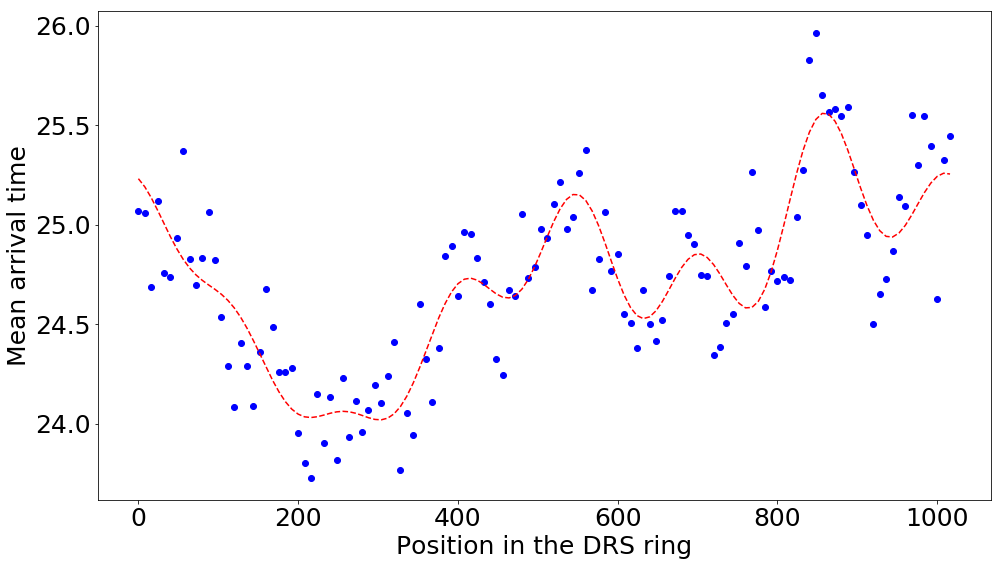

41


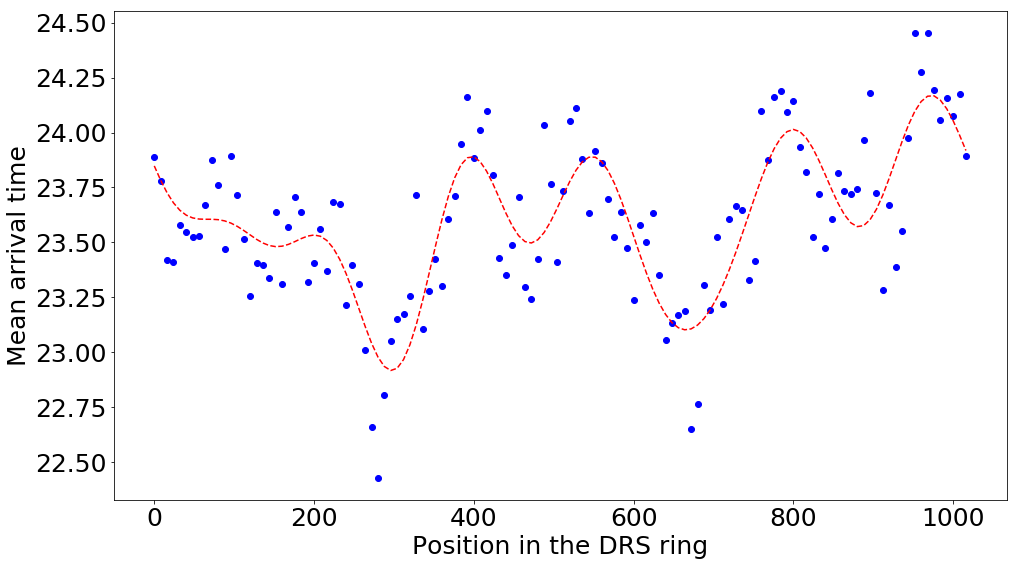

42


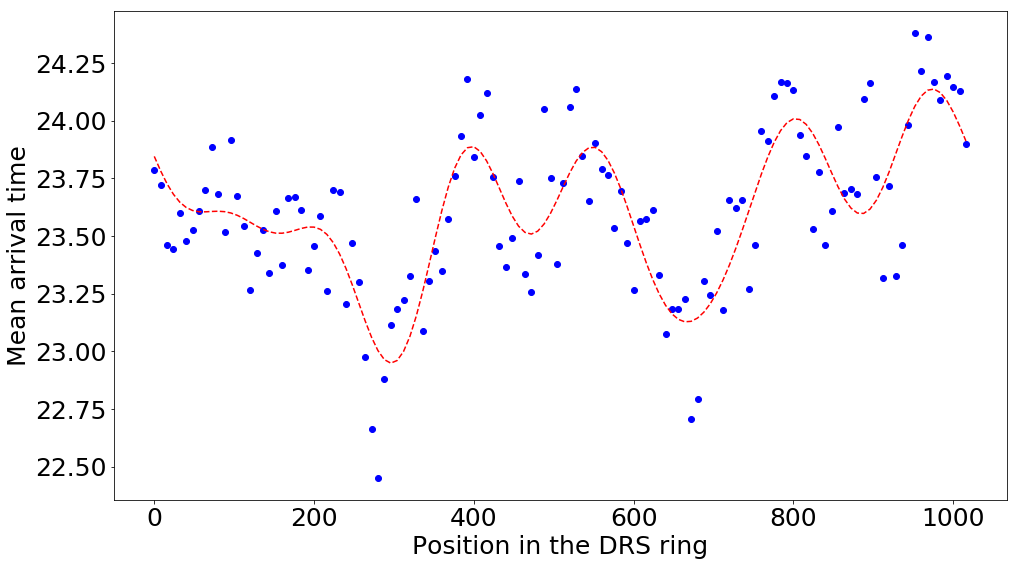

43


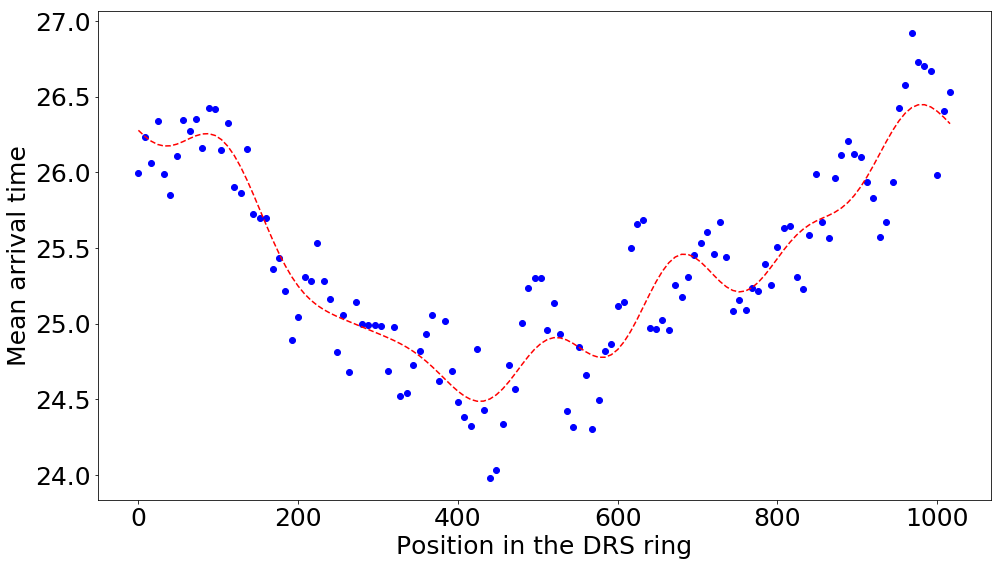

44


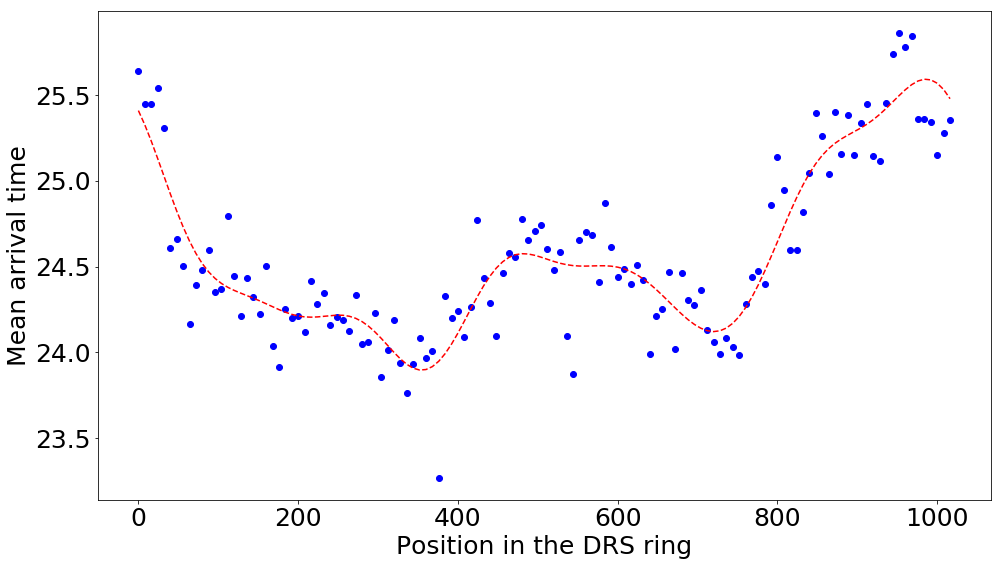

45


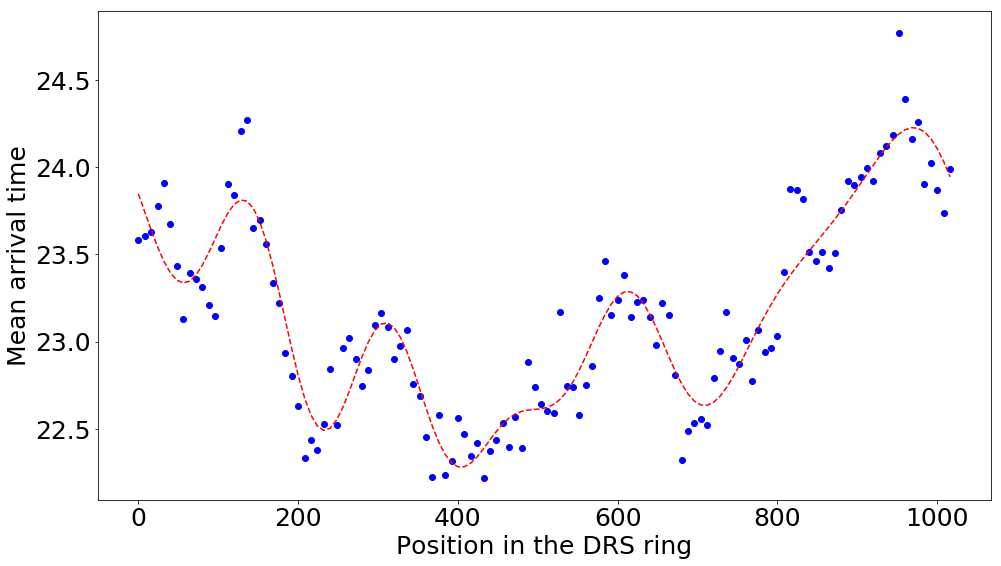

46


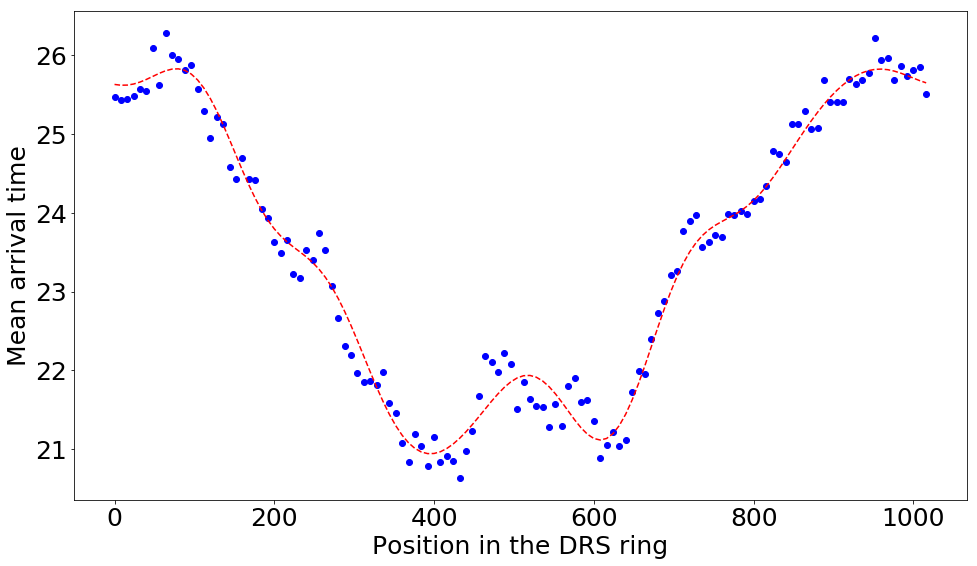

47


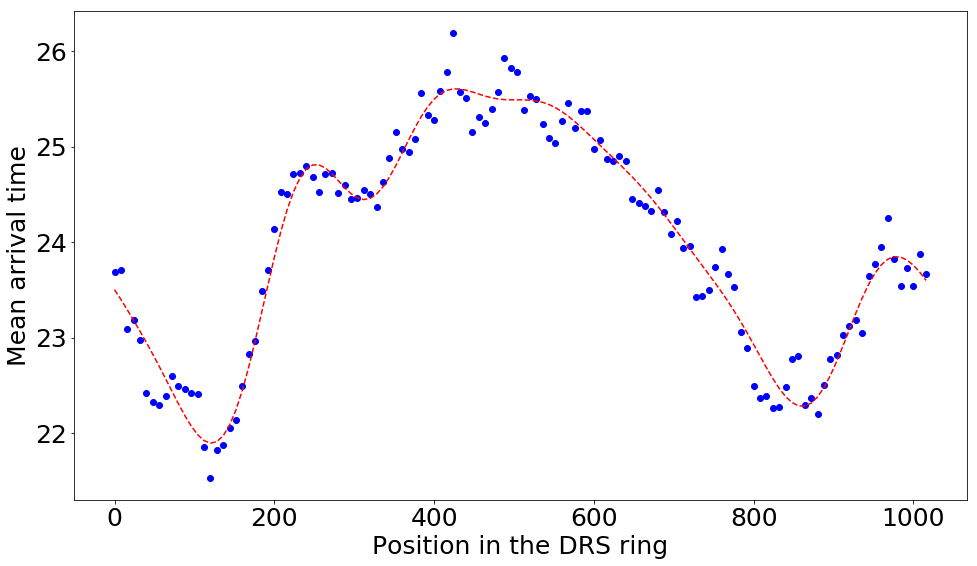

48


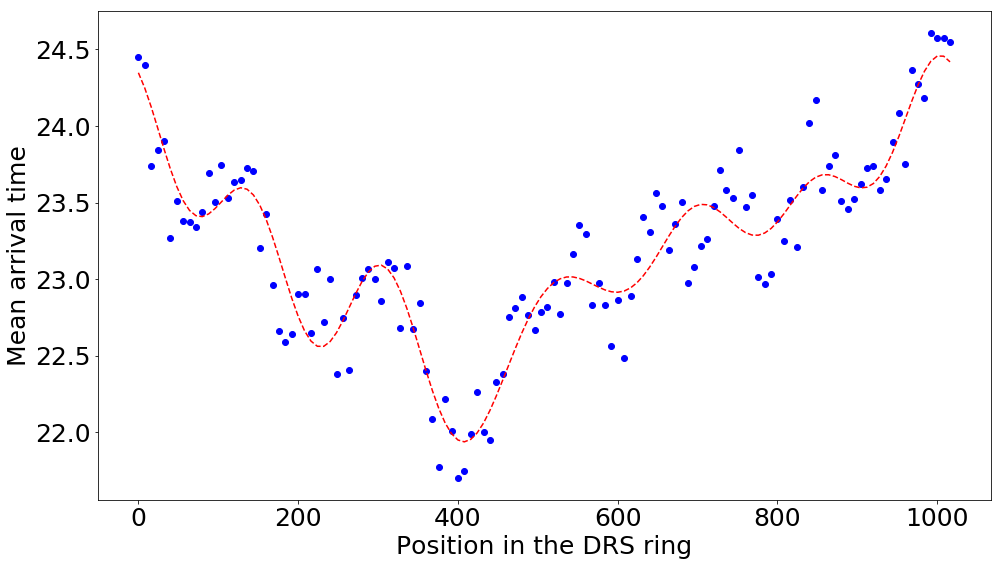

49


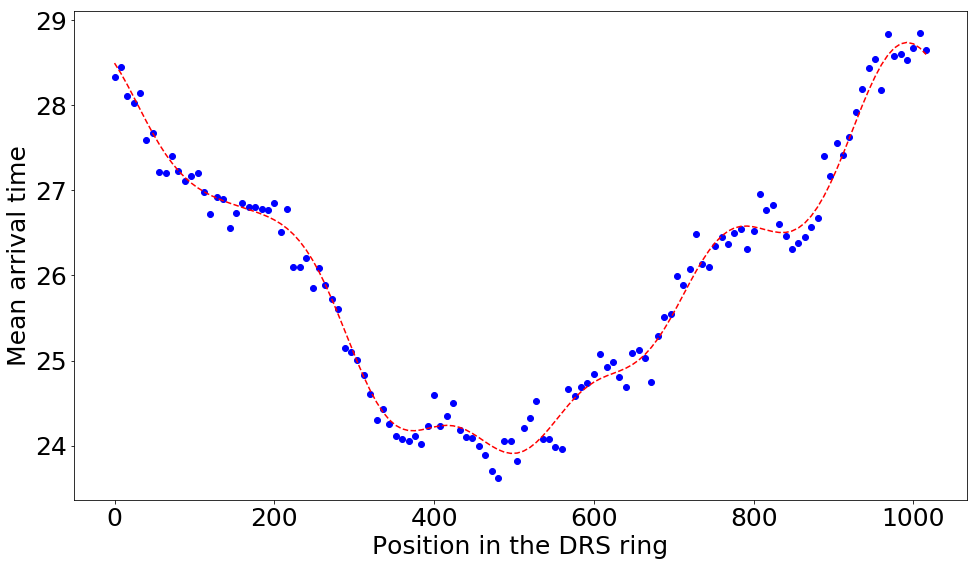

50


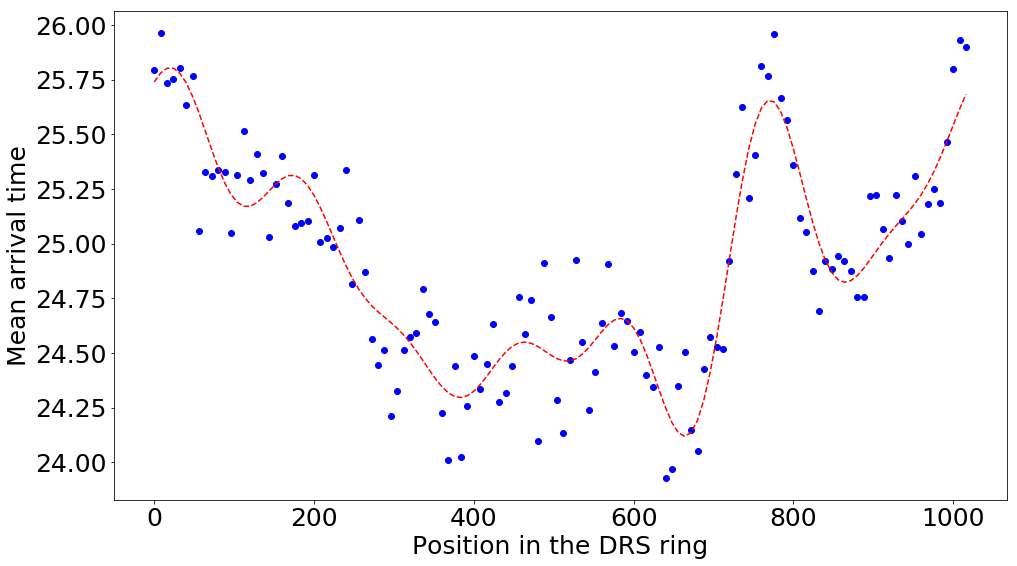

51


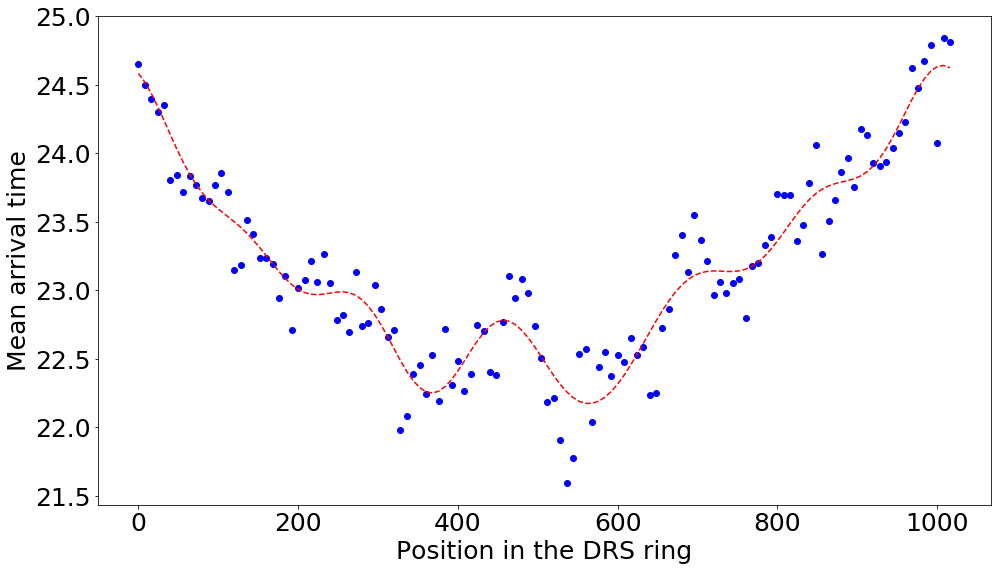

In [39]:
gain = 1
for pix_id in range(40, 52):
    print(pix_id)
    pixel_id = pix_id
    timeCorr.fit(pix_id, gain=gain)
    an = timeCorr.fan
    bn = timeCorr.fbn
    fMeanVal = timeCorr.fMeanVal[gain, pix_id]
    plot_corr_curve(n, n_cap, n_combine, an, bn, fMeanVal)
    plt.show()

In [10]:
fan_array = np.zeros((2, 1855, n_harm))
fbn_array = np.zeros((2, 1855, n_harm))
for pix_id in range(0, 1855):
    timeCorr.fit(pix_id, gain=0)
    fan_array[0, pix_id, :] = timeCorr.fan
    fbn_array[0, pix_id, :] = timeCorr.fbn
    
    timeCorr.fit(pix_id, gain=1)
    fan_array[1, pix_id, :] = timeCorr.fan
    fbn_array[1, pix_id, :] = timeCorr.fbn

In [11]:
try:
    hf = h5py.File('coeff_run1625_n_harm_8.h5', 'w')
    hf.create_dataset('fan', data=fan_array)
    hf.create_dataset('fbn', data=fbn_array)
    hf.attrs['run id'] = 1625
    hf.attrs['n_harm'] = 8
except Exception as err:
    print("FAILED!", err)

hf.close()

In [17]:
fan_array

array([[[ 4.83826715e+01,  8.09533543e-01, -1.24077510e-01, ...,
         -1.48898141e-02, -3.24815885e-02,  3.08668403e-02],
        [ 4.78696633e+01,  3.98420701e-01,  1.80554462e-01, ...,
          4.44923825e-02,  4.30579596e-03,  5.16856546e-02],
        [ 4.94546015e+01,  4.61520700e-01,  1.23054498e-01, ...,
         -3.10654535e-02, -1.12311350e-03,  2.70671527e-04],
        ...,
        [ 4.63054028e+01,  4.23943161e-01,  2.04549791e-01, ...,
          2.09513011e-02, -1.41137702e-03, -7.32985852e-03],
        [ 4.43318897e+01,  5.59319762e-01,  3.54896058e-01, ...,
          4.39073241e-02, -2.40657735e-02,  1.07111670e-02],
        [ 4.53126653e+01,  9.94831054e-01,  1.33238965e-01, ...,
         -7.56312091e-02, -5.52309336e-02,  2.94027241e-02]],

       [[ 5.00370676e+01,  2.87297404e-04,  3.33923975e-01, ...,
         -2.55558784e-02,  7.87875849e-04, -6.83309807e-02],
        [ 5.02980995e+01, -1.45161525e-01,  2.28299141e-01, ...,
         -1.20460735e-02, -1.33369151e

@ JIT

In [5]:
%%time

reader = LSTEventSource(input_url=input_file_1, max_events=10000)
lst_r0 = LSTR0Corrections(config=config_corr)

n_combine = 8
n_harm = 16
n_cap = 1024
timeCorr = TimeCalCorr(n_combine, n_harm, n_cap, offset=0, tel_id=1)


for i, ev in enumerate(reader):
    if ev.r0.event_id%500 == 0:
        print(ev.r0.event_id)
        
    lst_r0.calibrate(ev)
    
    timeCorr.call_calib_pulse_time_jit(ev)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
CPU times: user 4min 20s, sys: 6.32 s, total: 4min 27s
Wall time: 2min 32s


In [6]:
timeCorr.finalize()

10


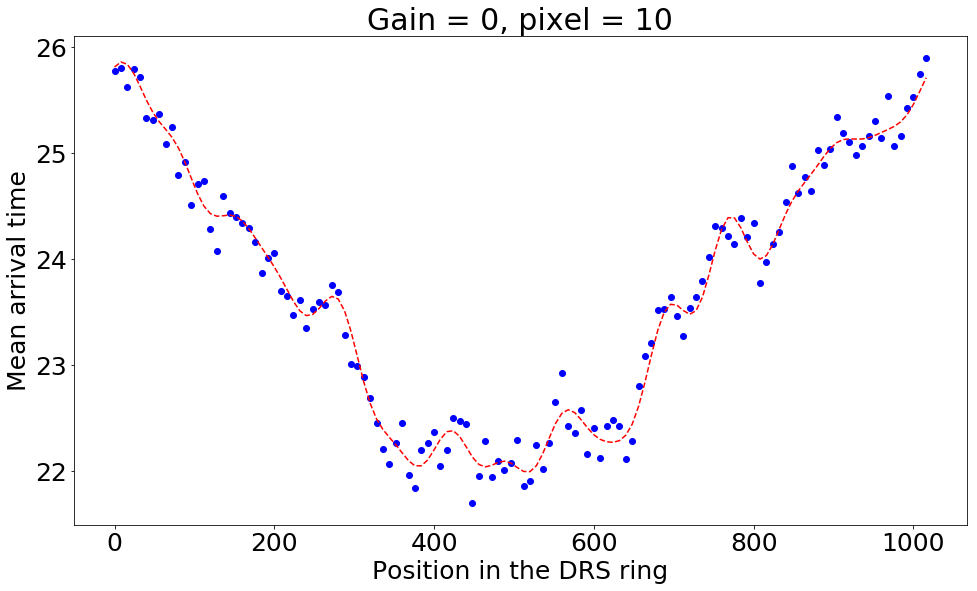

150


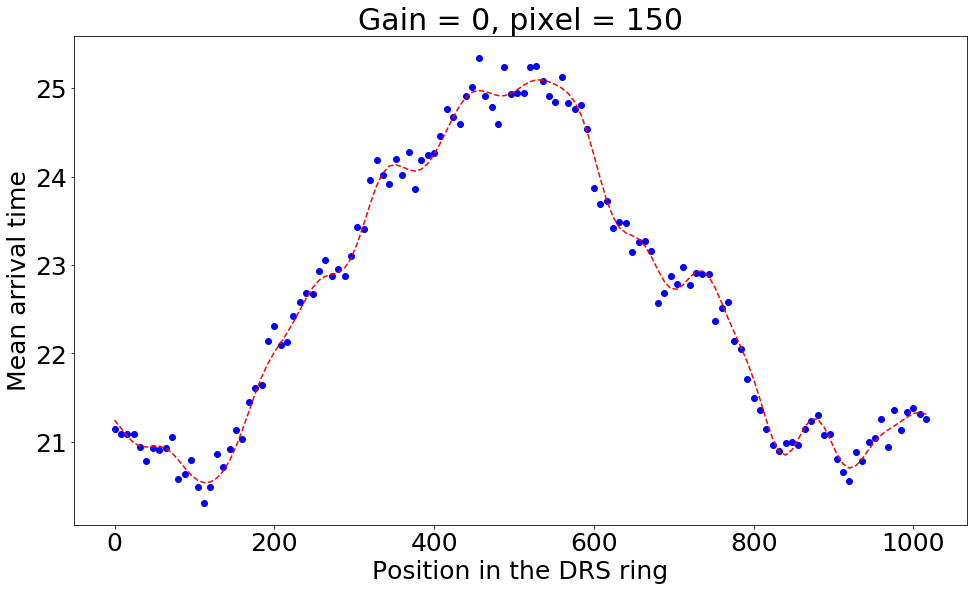

250


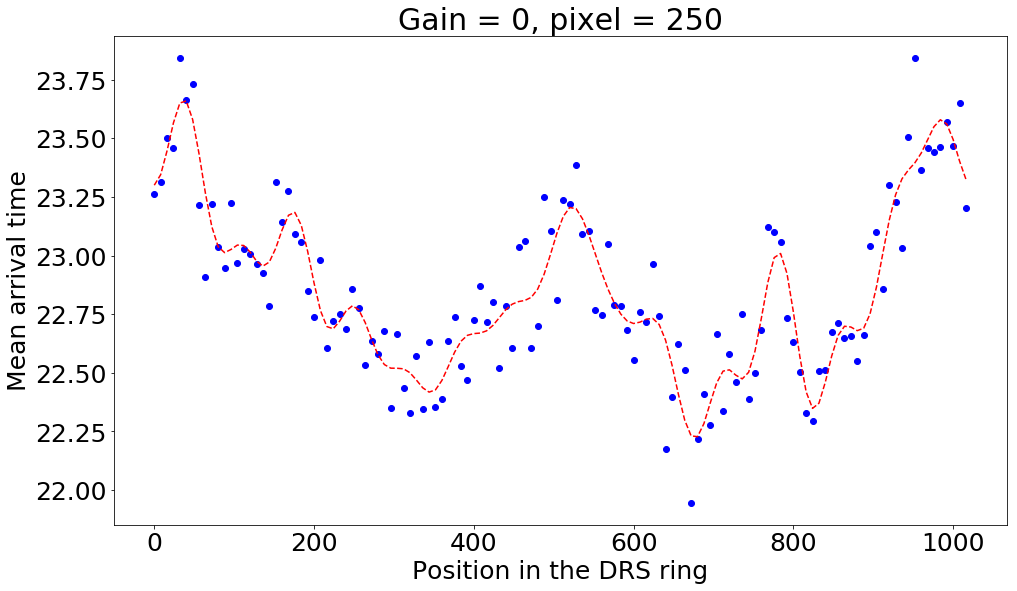

280


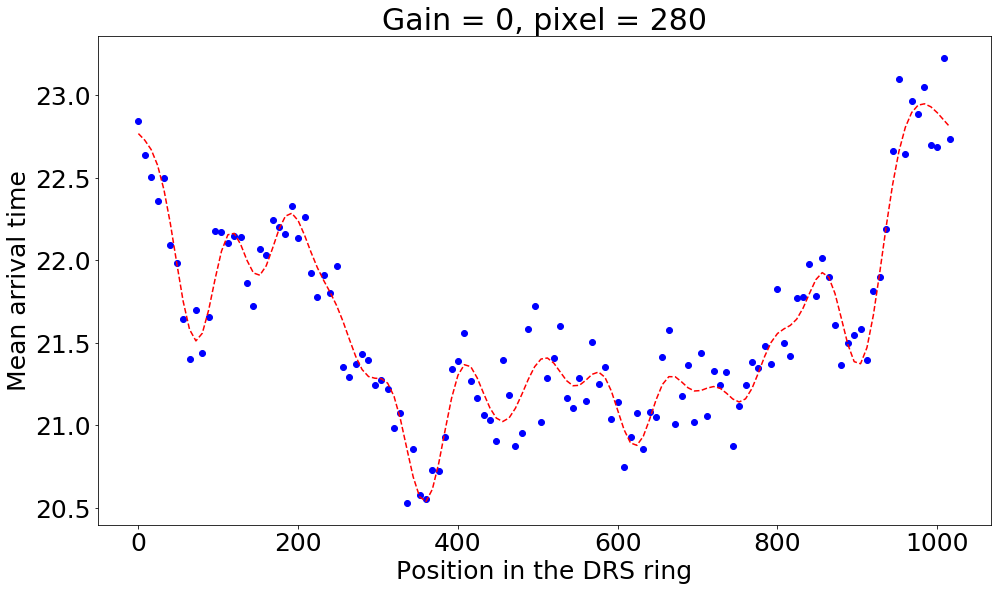

1000


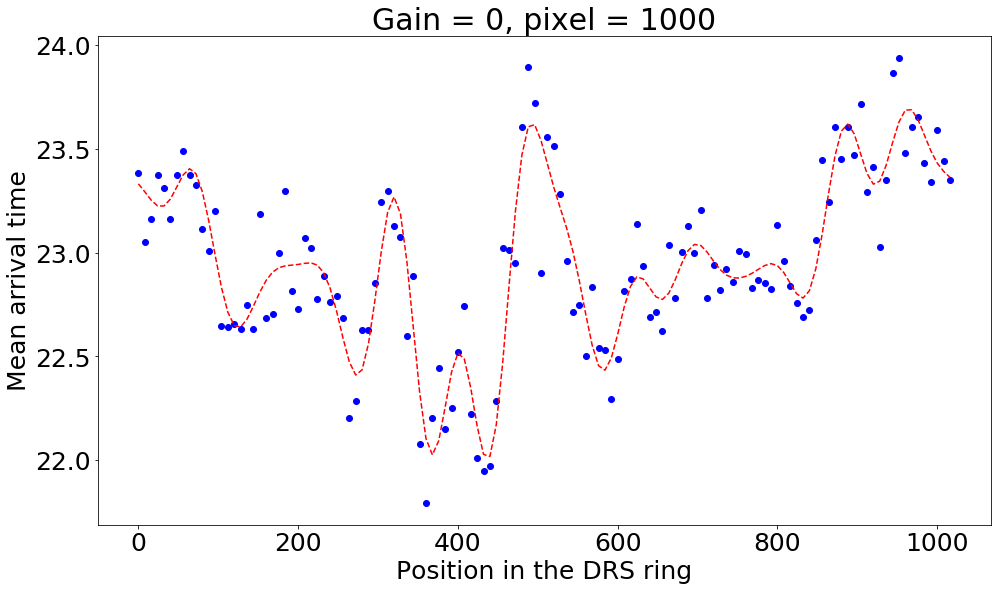

1200


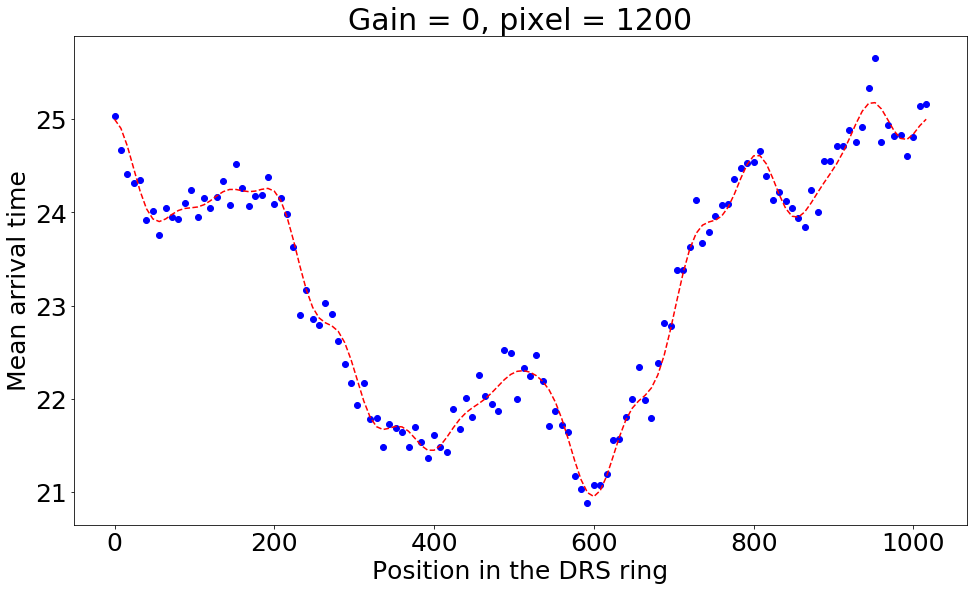

10


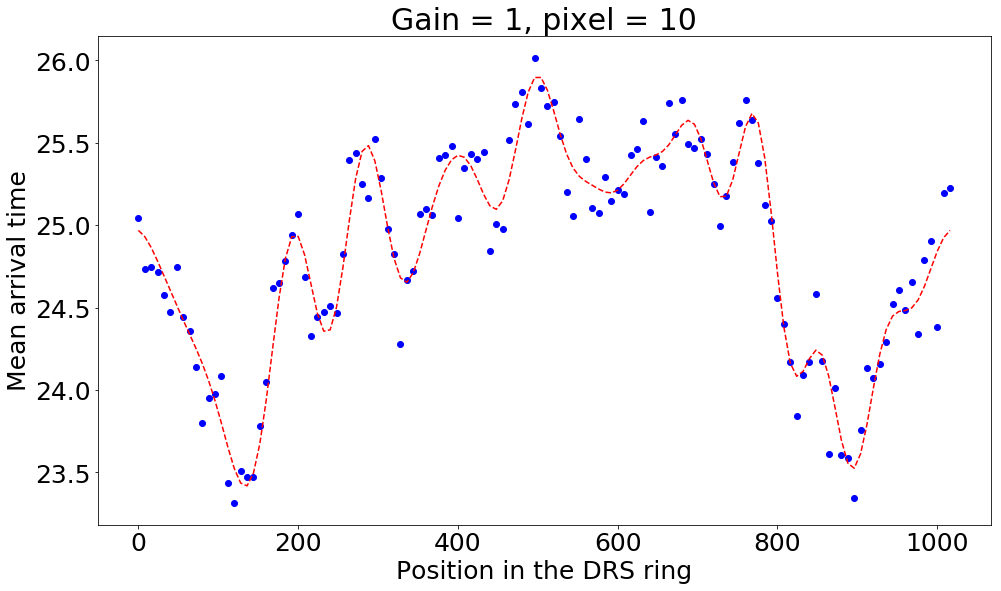

150


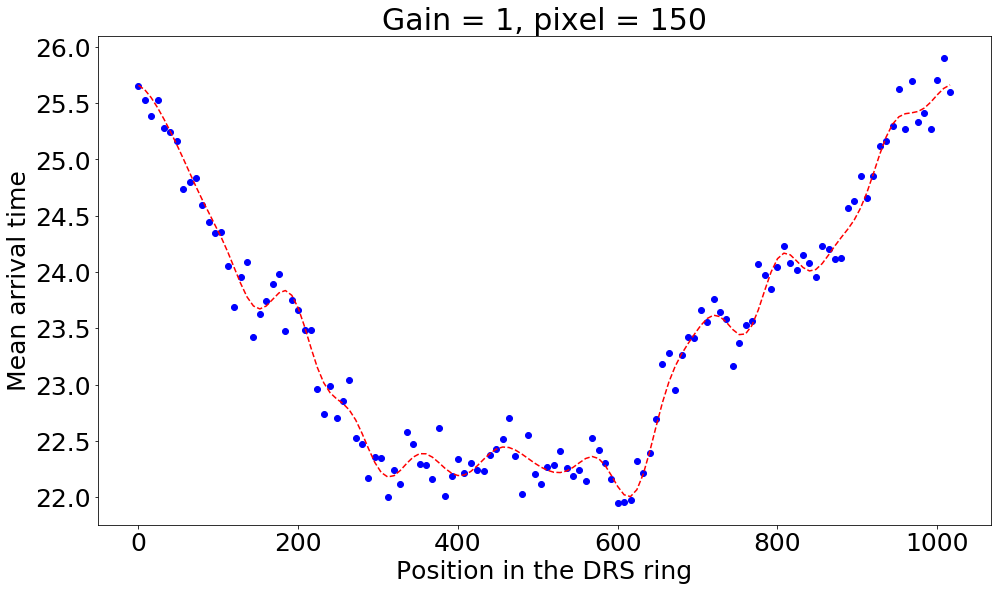

250


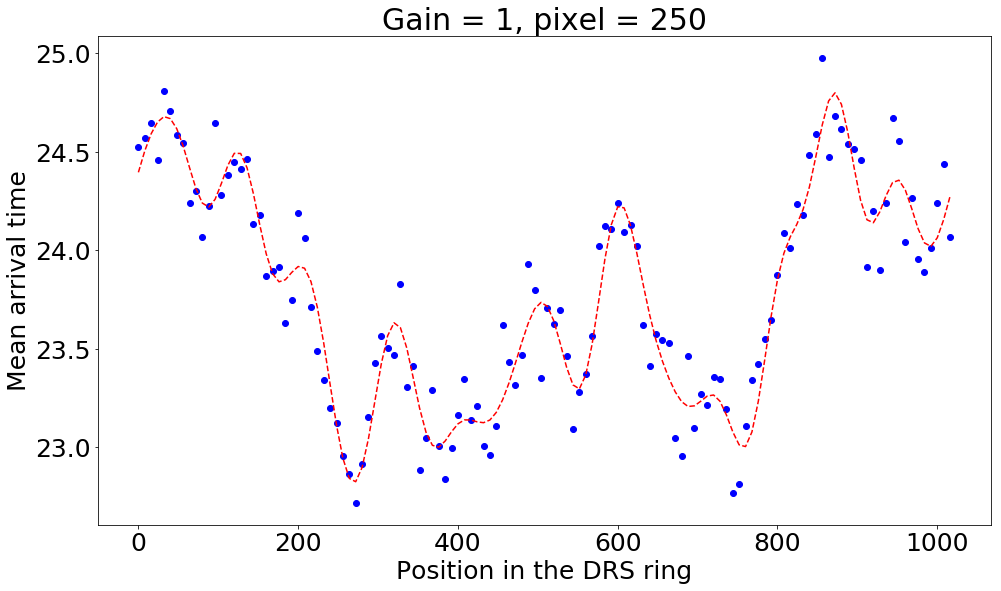

280


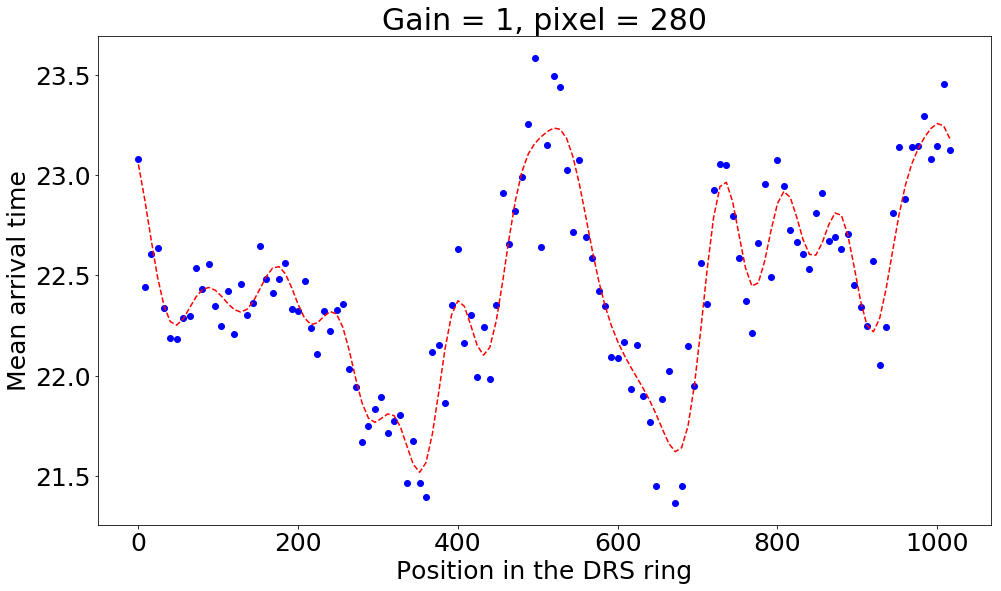

1000


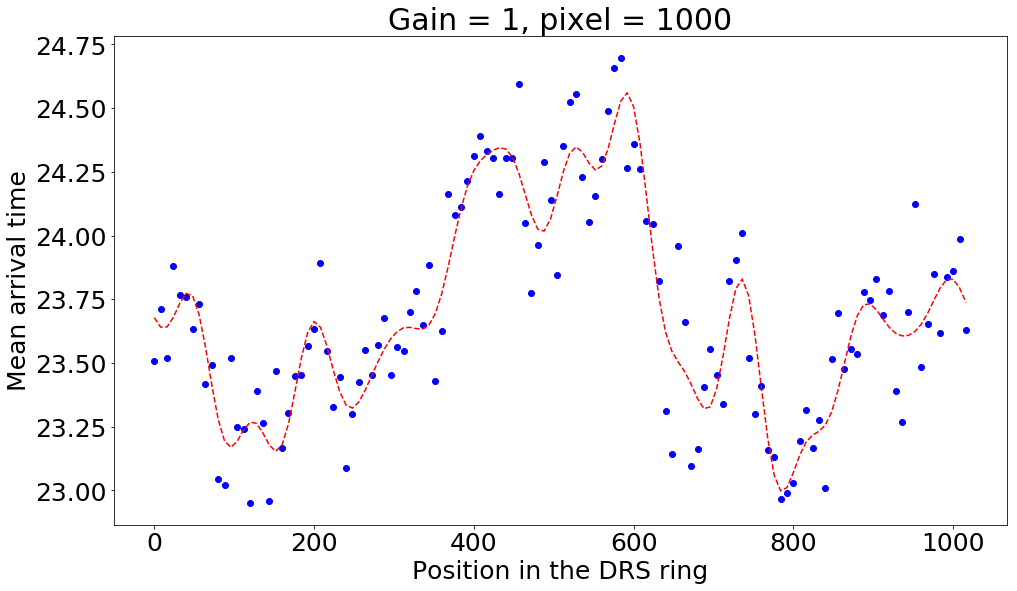

1200


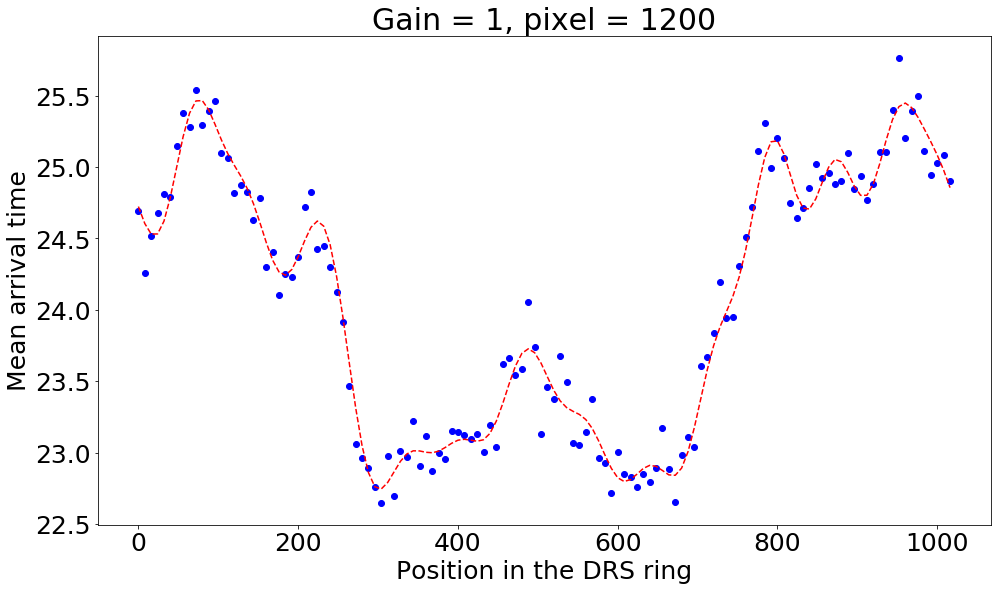

In [15]:
pdf = matplotlib.backends.backend_pdf.PdfPages("plots/output.pdf")
for gain in [0, 1]:
    for pix_id in [10, 150, 250, 280, 1000, 1200]:
        print(pix_id)
        pixel_id = pix_id
        timeCorr.fit(pix_id, gain=gain)
        an = timeCorr.fan
        bn = timeCorr.fbn
        fMeanVal = timeCorr.fMeanVal[gain, pix_id]
        fig = plot_corr_curve(n, n_cap, n_combine, an, bn, fMeanVal)
        plt.title("Gain = {}, pixel = {}".format(gain, pix_id))
        pdf.savefig( fig )
        plt.show()
    
pdf.close()

In [44]:
fan_array = np.zeros((2, 1855, n_harm))
fbn_array = np.zeros((2, 1855, n_harm))
for pix_id in range(0, 1855):
    timeCorr.fit(pix_id, gain=0)
    fan_array[0, pix_id, :] = timeCorr.fan
    fbn_array[0, pix_id, :] = timeCorr.fbn
    
    timeCorr.fit(pix_id, gain=1)
    fan_array[1, pix_id, :] = timeCorr.fan
    fbn_array[1, pix_id, :] = timeCorr.fbn

try:
    hf = h5py.File('coeff_run1625_n_harm_16.h5', 'w')
    hf.create_dataset('fan', data=fan_array)
    hf.create_dataset('fbn', data=fbn_array)
    hf.attrs['run id'] = 1625
    hf.attrs['n_harm'] = 16
    hf.attrs['n events'] = 30000
except Exception as err:
    print("FAILED!", err)

hf.close()

In [47]:
! ls

calib_time.py			  param.json	       time_cal_corr.py
coeff_run1625_n_harm_16.h5	  provenance.log       tools.py
coeff_run1625_n_harm_8.h5	  pulse_correction.py  Untitled.ipynb
fit_curve_and_create_coeff.ipynb  __pycache__
